# UniNa - Data Mining 20/21 - MiniContest n2
## Land Surface Temperature Evaluation from Satellite Data
https://www.kaggle.com/c/unina-data-mining-2021-minicontest-n2/overview

## 1. Introduction
This notebook shows the solution proposed for the second Mini-Contest of the Data Mining course of University of Naples Federico II. 

The aim of the contest is to determine the Land Surface Temperature (LST) from satellite data. We will use data coming from the National Aeronautics and Space Administration (NASA) Landsat-8 missions.

The performance measure to minimize is the **Mean Absolute Error** (MAE).

### 1.1. Import relevant modules

In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

# Utilities
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'

### 1.2. Read the dataset

#### Training set

In [3]:
df_train_rough = pd.read_excel('dataset/TrainingSet.xlsx')
df_train_rough.head()

,ID,lat,lon,B2,B3,B4,B5,B6,B7,MONTH,LST
0,1.0,-118.886195,34.387831,0.098286,0.123105,0.185289,0.319676,0.374198,0.298471,5,30.45
1,2.0,-119.142533,33.979111,0.062934,0.034248,0.072786,0.047289,0.029919,0.022151,5,13.45
2,5.0,-118.239593,34.340886,0.068062,0.088085,0.149781,0.472569,0.275960,0.184450,5,27.25
3,6.0,-117.723504,33.748967,0.069445,0.067300,0.124280,0.168265,0.309019,0.276433,5,31.45
4,7.0,-118.741144,34.284916,0.100648,0.122068,0.169877,0.274852,0.237607,0.190891,5,35.85


In [4]:
print('The training set contains {:d} columns and {:d} rows.'.format(df_train_rough.shape[1], df_train_rough.shape[0]))

The training set contains 11 columns and 38492 rows.


In [5]:
df_train_rough.dtypes

ID       float64
lat      float64
lon      float64
B2       float64
B3       float64
B4       float64
B5       float64
B6       float64
B7       float64
MONTH      int64
LST      float64
dtype: object

The dataset contains only numerical features. Let's change the type of ID column from *float64* to *int64*, as required by Kaggle.

In [6]:
df_train_rough = df_train_rough.astype({'ID': 'int64'})

In [7]:
df_train_rough.isnull().sum()

ID       0
lat      0
lon      0
B2       0
B3       0
B4       0
B5       0
B6       0
B7       0
MONTH    0
LST      0
dtype: int64

There aren't missing values in the training set.

#### Test set

In [8]:
df_test_rough = pd.read_excel('dataset/TestSet.xlsx')
df_test_rough.head()

,ID,lat,lon,B2,B3,B4,B5,B6,B7,MONTH
0,0.0,-117.795834,34.582758,0.147166,0.207798,0.311656,0.398791,0.521087,0.453670,5
1,3.0,-118.796802,33.891571,0.066897,0.032199,0.070760,0.040257,0.018909,0.011465,5
2,4.0,-118.589392,34.330183,0.036695,0.047750,0.091988,0.351815,0.207875,0.110462,5
3,8.0,-118.171579,34.089719,0.129285,0.138377,0.188247,0.265811,0.237913,0.196772,5
4,12.0,-117.944779,34.579266,0.133184,0.176745,0.258734,0.329934,0.400507,0.365546,5


In [9]:
print('The test set contains {:d} columns and {:d} rows.'.format(df_test_rough.shape[1], df_test_rough.shape[0]))

The test set contains 10 columns and 19830 rows.


In [10]:
df_test_rough.dtypes

ID       float64
lat      float64
lon      float64
B2       float64
B3       float64
B4       float64
B5       float64
B6       float64
B7       float64
MONTH      int64
dtype: object

In [11]:
df_test_rough = df_test_rough.astype({'ID': 'int64'})

In [12]:
df_test_rough.isnull().sum()

ID       0
lat      0
lon      0
B2       0
B3       0
B4       0
B5       0
B6       0
B7       0
MONTH    0
dtype: int64

## 2. Data Analysis
The dataset is made up of 11 feature (considering the class attribute of the training set):
- **ID**: numeric identifier;
- **lat**: latitude of the tile observed by the satellite;
- **lon**: longitude of the tile observed by the satellite;
- **B2**-**B7**: Landsat-8 spectral band's values of the tile observed by the satellite;
- **MONTH**: observation's month;
- **LST**: land surface temperature of the tile observed by the satellite;

Here wee report more information about the spectral bands available of Landsat-8:

| Band | Wavelength ($µm$) | Resolution ($m$)|
| :-- | :-- | :-- |
| B2 - Blue | 0.450–0.515 | 30 |
| B3 - Green | 0.525–0.600 | 30 |
| B4 - Red | 0.630–0.680 | 30 |
| B5 - Near Infrared (NIR)| 0.845–0.885 | 30 |
| B6 - Shortwave Infrared 1 (SWIR1) | 1.560–1.660 | 30 |
| B7 - Shortwave Infrared 2 (SWIR2) | 2.100–2.300 | 30 |

Now, let's look at some basic descriptive statistics of both training and test set.

In [13]:
df_train_rough.describe()

,ID,lat,lon,B2,B3,B4,B5,B6,B7,MONTH,LST
count,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000,38492.000000
mean,42494.212200,-118.378554,34.107935,0.094226,0.106873,0.144256,0.258016,0.216044,0.157996,5.284267,27.323543
std,27820.920229,0.497993,0.242894,0.077390,0.081962,0.095827,0.150356,0.135662,0.106565,3.283815,11.459535
min,1.000000,-119.406334,33.562429,0.018193,0.018318,0.039256,0.014172,0.001100,0.000670,1.000000,-8.250000
25%,14527.500000,-118.793200,33.916328,0.057575,0.058739,0.082438,0.175114,0.136359,0.089097,2.000000,17.450000
50%,53131.500000,-118.319944,34.111520,0.073476,0.090876,0.127297,0.267098,0.217933,0.154235,5.000000,25.450000
75%,67766.250000,-117.937464,34.300926,0.102374,0.125643,0.174922,0.342374,0.295600,0.215512,8.000000,37.150000
max,82427.000000,-117.543920,34.651219,0.935374,0.968355,1.096925,1.394706,0.988942,0.813560,12.000000,59.450000


In [14]:
df_test_rough.describe()

,ID,lat,lon,B2,B3,B4,B5,B6,B7,MONTH
count,19830.000000,19830.000000,19830.000000,19830.000000,19830.000000,19830.000000,19830.000000,19830.000000,19830.000000,19830.000000
mean,42780.430408,-118.380075,34.108812,0.094000,0.106595,0.143960,0.257576,0.215598,0.157809,5.280535
std,27806.021604,0.496144,0.242377,0.077296,0.081774,0.095435,0.150276,0.135082,0.106057,3.292691
min,0.000000,-119.406334,33.562429,0.017324,0.020839,0.039065,0.011418,0.000519,0.001070,1.000000
25%,14689.250000,-118.801229,33.917414,0.057544,0.058688,0.081980,0.175134,0.135341,0.088539,2.000000
50%,53534.500000,-118.321006,34.113467,0.073874,0.091025,0.127085,0.266545,0.217299,0.154048,5.000000
75%,67974.750000,-117.938119,34.302727,0.102355,0.125861,0.175550,0.340650,0.294916,0.216164,8.000000
max,82426.000000,-117.543920,34.651219,0.966814,1.008822,1.008822,1.140665,0.815582,0.621550,12.000000


It seems that latitude and longitude have been swapped, since latitude in decimal degrees format should range from -90 to +90, whereas longitude from -180 to +180.

In [15]:
df_train_rough.rename(columns={'lat':'lon', 'lon':'lat'}, inplace=True)
df_test_rough.rename(columns={'lat':'lon', 'lon':'lat'}, inplace=True)

Now we can plot the distributions of our features.

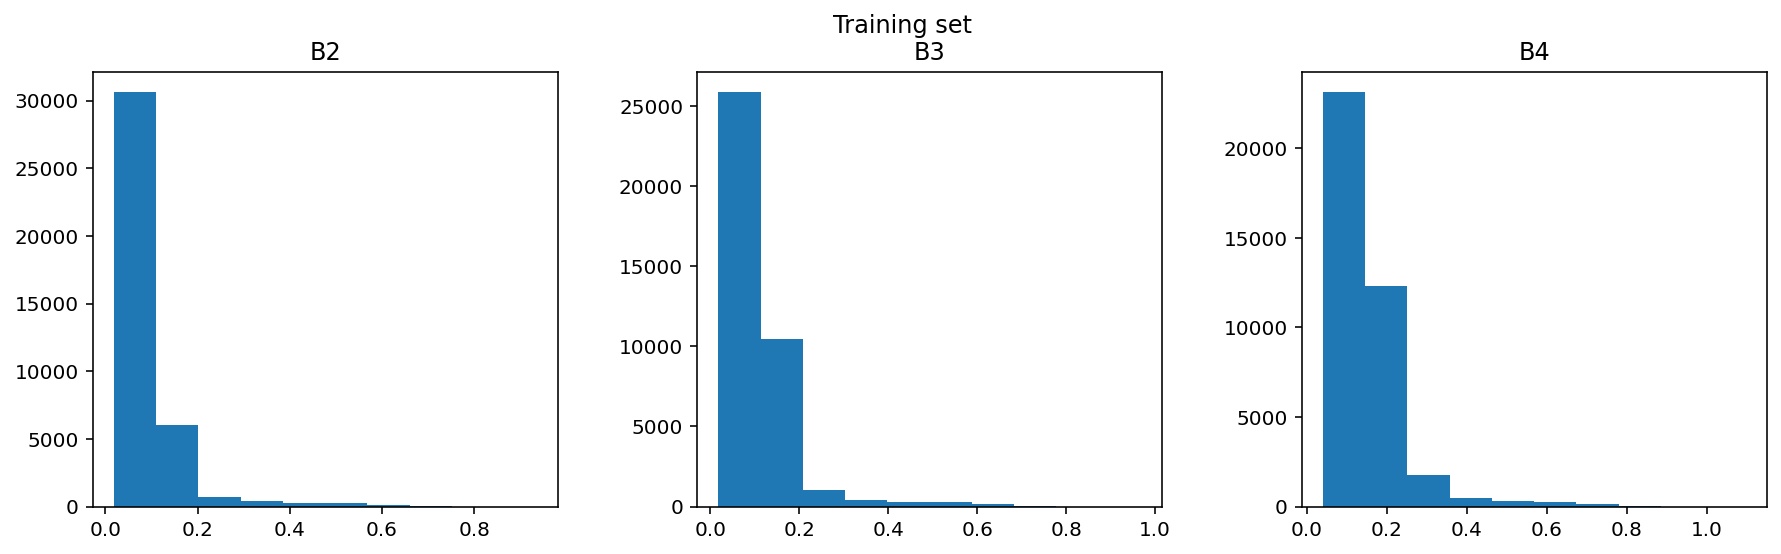

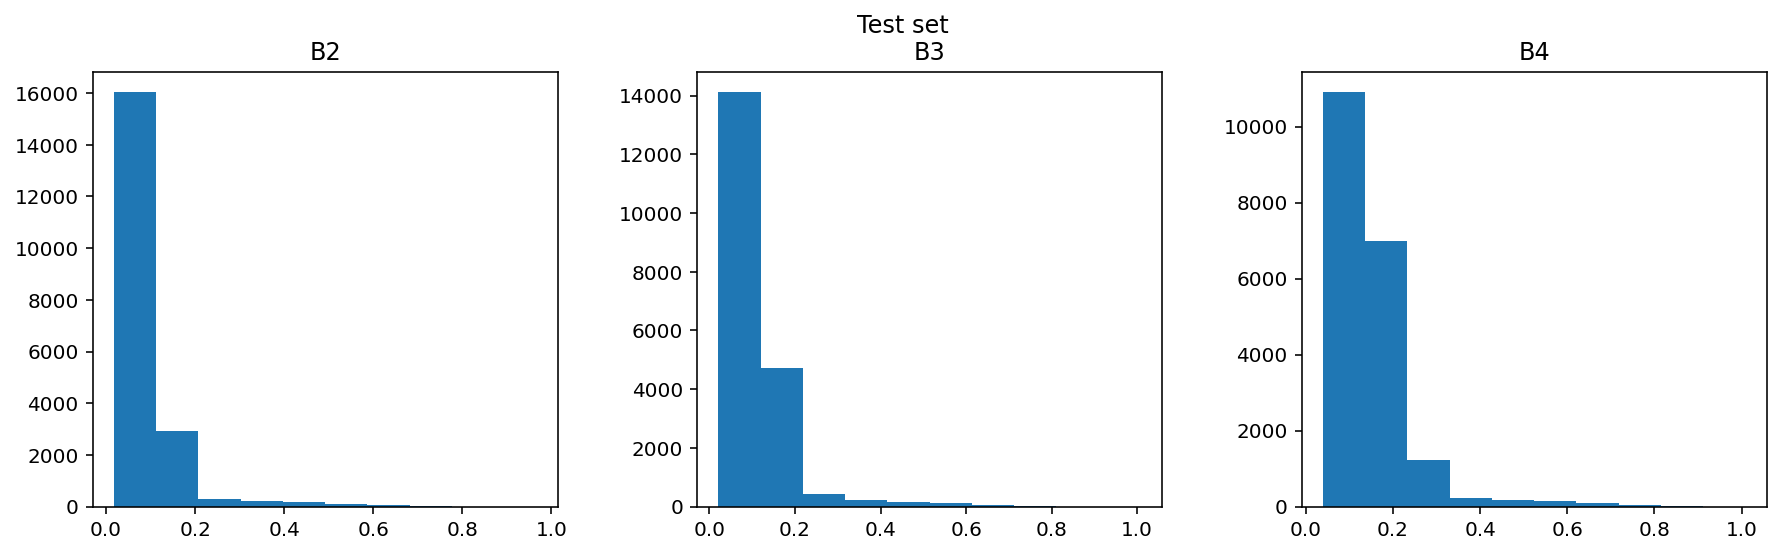

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_train_rough.hist(column=['B2', 'B3', 'B4'], grid=False, ax=axs)
plt.suptitle('Training set')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_test_rough.hist(column=['B2', 'B3', 'B4'], grid=False, ax=axs)
plt.suptitle('Test set')
plt.show()

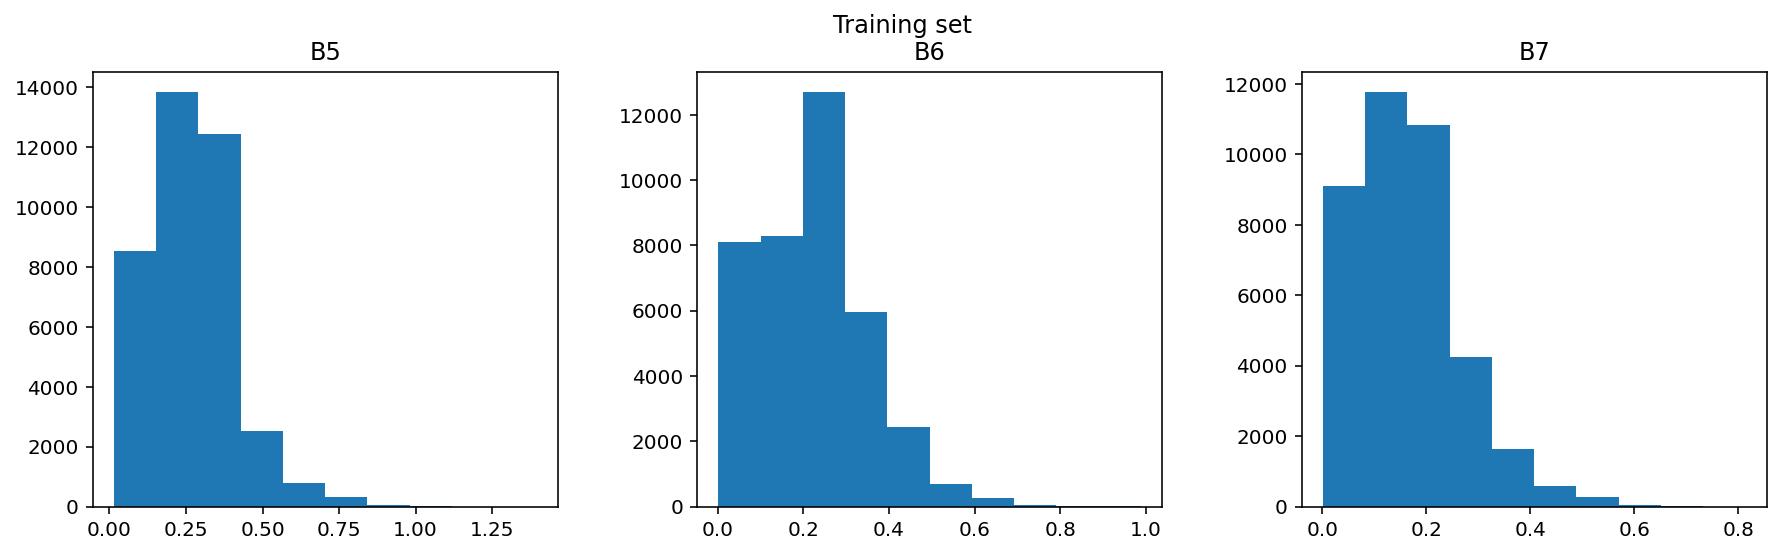

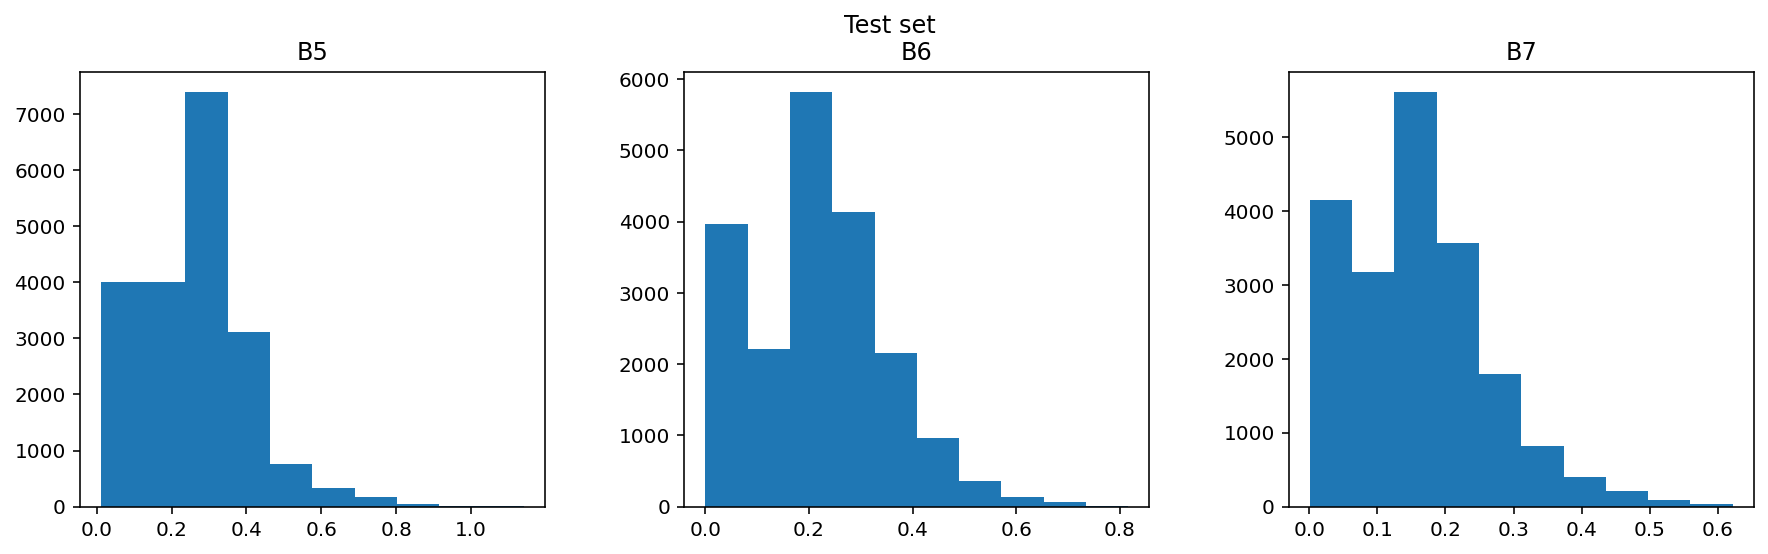

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_train_rough.hist(column=['B5', 'B6', 'B7'], grid=False, ax=axs)
plt.suptitle('Training set')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_test_rough.hist(column=['B5', 'B6', 'B7'], grid=False, ax=axs)
plt.suptitle('Test set')
plt.show()

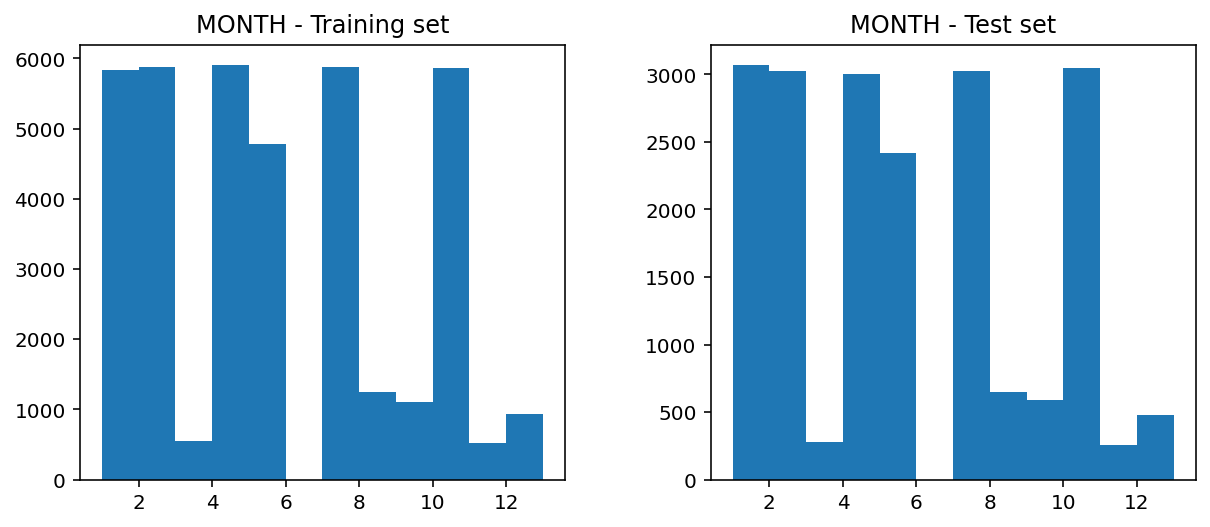

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
df_train_rough.hist(column=['MONTH'], bins=np.arange(1,14), grid=False, ax=axs[0])
df_test_rough.hist(column=['MONTH'], bins=np.arange(1,14), grid=False, ax=axs[1])
axs[0].set_title('MONTH - Training set')
axs[1].set_title('MONTH - Test set')
plt.show()

It seems that all features lie in plausible ranges.

Finally let's plot class distribution.

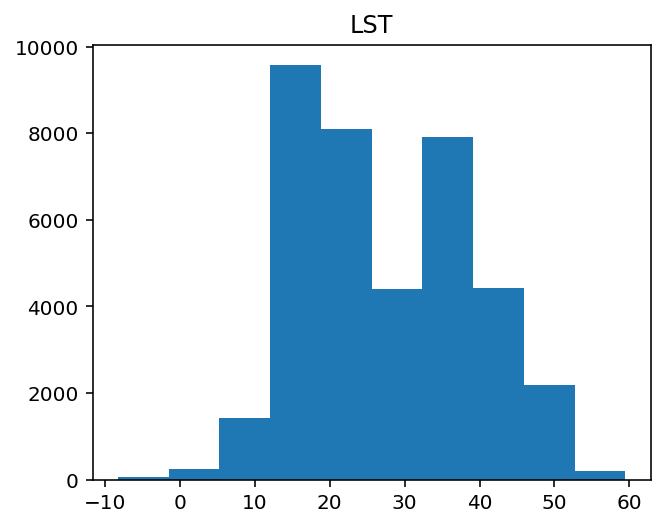

In [19]:
df_train_rough.hist(column=['LST'], figsize=(5,4), grid=False)
plt.show()

## 3. Feature engineering
Now we can start the feature engineering process, which aims to extract new features from the dataset.

Let's consider the whole dataset in this stage.

In [20]:
df_feature = df_train_rough.append(df_test_rough, ignore_index=True, sort=False)

### 3.1. Spectral indices and LST
According to the state of the art, some indicators of LST are the so called **normalised difference spectral indices**. The normalised difference spectral index using bands $i$ and $j$ is defined as:<br>
<center>$SI_{B_i-B_j} = \frac{p_j-p_i}{p_j+p_i|}$</center> 

where $p_j$ and $p_i$ are surface reflectances of bands $i$ and $j$, respectively.

Some of these indices are widely used in the literature, such as the $SI_{B_4-B_5}$, which is the well-known NDVI.

In [21]:
band = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
for i in range(len(band)-1):
    b1 = band[i]
    for j in range(i+1, len(band)):
        b2 = band[j]
        f = 'SI_' + b1 + b2
        df_feature[f] = (df_feature[b2]-df_feature[b1])/(df_feature[b2]+df_feature[b1])

### 3.2. Spatial pattern of LST
Another essential factor for estimation of LST is **emissivity** $\epsilon$, the efficiency of transmitting thermal energy.
An important component of emissivity is the **proportion of vegetation** $P_v$, which can be estimated using NDVI:<br>
<center>$P_v = \frac{NDVI-NDVI_s}{NDVI_v-NDVI_s}$</center> 

where $NDVI_s$ and $NDVI_v$ represent NDVI values for soil ($0.2$) and vegetation ($0.5$), respectively.

In [22]:
df_feature['PV'] = np.square((df_feature['SI_B4B5']-0.2)/(0.5-0.2))

Emissivity values can be estimated as:<br>
<center>
$
\begin{equation}
\epsilon =
\begin{cases}
0.991 & \text{if $NDVI < 0$} \\
0.996 & \text{if $0 \le NDVI < 0.2$}\\
\epsilon_v P_v + \epsilon_s (1-P_v) + C_\lambda \qquad & \text{if $0.2 \le NDVI \le 0.5$}\\
0.973 & \text{if $NDVI > 0.5$}\\
\end{cases}
\end{equation}
$
</center> 

where $\epsilon_v$ and $\epsilon_s$ are the vegetation ($0.973$) and soil ($0.996$) emissivities, respectively, and $C_\lambda$ represents the surface roughness ($0.005$). 

In [23]:
df_feature.loc[df_feature.SI_B4B5<0, 'eps'] = 0.991
df_feature.loc[(df_feature.SI_B4B5>=0) & (df_feature.SI_B4B5<0.2), 'eps'] = 0.996
df_feature.loc[(df_feature.SI_B4B5>=0.2) & (df_feature.SI_B4B5<=0.5), 'eps'] = 0.973 * df_feature.PV + 0.996 * (1-df_feature.PV) + 0.005
df_feature.loc[df_feature.SI_B4B5>0.5, 'eps'] = 0.973

According to some studies, LST depend on the natural logarithm of emissivity.

In [24]:
df_feature['eps'] = np.log(df_feature.eps)

## 4. Feature selection
Before moving forward with the modelling stage, we need to select the best features to use as input to our model.

Let'split again the dataset in training and test set.

In [25]:
df_train = df_feature.dropna(subset=['LST']).copy()

In [26]:
df_test = df_feature.loc[df_feature.LST.isna()].copy()

### 4.1. Correlation
Now we can look at the **correlation matrix** of the training set. The idea is to select features that are strongly correlated to LST and loosely correlated to other features.

In [27]:
df_train.corr()

,ID,lon,lat,B2,B3,B4,B5,B6,B7,MONTH,...,SI_B3B6,SI_B3B7,SI_B4B5,SI_B4B6,SI_B4B7,SI_B5B6,SI_B5B7,SI_B6B7,PV,eps
ID,1.000000,0.008273,-0.024077,-0.166397,-0.165104,-0.170012,-0.180735,-0.121121,-0.122435,0.330246,...,-0.049833,-0.049634,-0.056419,-0.040991,-0.043135,-0.018040,-0.024089,-0.064524,0.032485,0.080774
lon,0.008273,1.000000,-0.201504,0.057595,0.147151,0.195261,0.277278,0.267438,0.268446,-0.030174,...,0.381503,0.386058,0.355288,0.369609,0.372389,0.265383,0.235319,0.087983,-0.386903,0.058905
lat,-0.024077,-0.201504,1.000000,-0.081457,0.022144,0.079694,0.253018,0.313832,0.280104,-0.017861,...,0.345402,0.343772,0.302065,0.341436,0.336464,0.250995,0.188854,-0.063524,-0.202221,-0.037866
B2,-0.166397,0.057595,-0.081457,1.000000,0.970851,0.930832,0.514480,0.546698,0.593817,-0.024880,...,-0.044911,-0.020407,-0.113621,-0.014570,0.022580,0.216382,0.268791,0.298939,-0.286097,0.299103
B3,-0.165104,0.147151,0.022144,0.970851,1.000000,0.980369,0.650001,0.692528,0.728700,-0.039033,...,0.119427,0.146425,0.040205,0.156826,0.197182,0.339796,0.373363,0.313848,-0.401779,0.291427
B4,-0.170012,0.195261,0.079694,0.930832,0.980369,1.000000,0.677920,0.775481,0.811934,0.017438,...,0.217571,0.253115,0.083542,0.234565,0.281869,0.446324,0.471533,0.347640,-0.492480,0.345897
B5,-0.180735,0.277278,0.253018,0.514480,0.650001,0.677920,1.000000,0.840785,0.744895,-0.014916,...,0.639409,0.607675,0.694415,0.684895,0.654187,0.373964,0.261845,-0.103947,-0.423374,-0.212960
B6,-0.121121,0.267438,0.313832,0.546698,0.692528,0.775481,0.840785,1.000000,0.970634,0.057530,...,0.660295,0.689394,0.500874,0.680783,0.715703,0.697578,0.627929,0.189575,-0.603655,0.139130
B7,-0.122435,0.268446,0.280104,0.593817,0.728700,0.811934,0.744895,0.970634,1.000000,0.036366,...,0.576575,0.634191,0.370860,0.591797,0.661138,0.728457,0.714911,0.371100,-0.634342,0.276126
MONTH,0.330246,-0.030174,-0.017861,-0.024880,-0.039033,0.017438,-0.014916,0.057530,0.036366,1.000000,...,0.038617,0.030714,-0.038690,-0.000301,-0.017343,0.049478,0.011737,-0.140593,-0.030542,0.091308


Correlation matrix as it is is not so readable. To make it easier to understand we can plot the related heatmap.

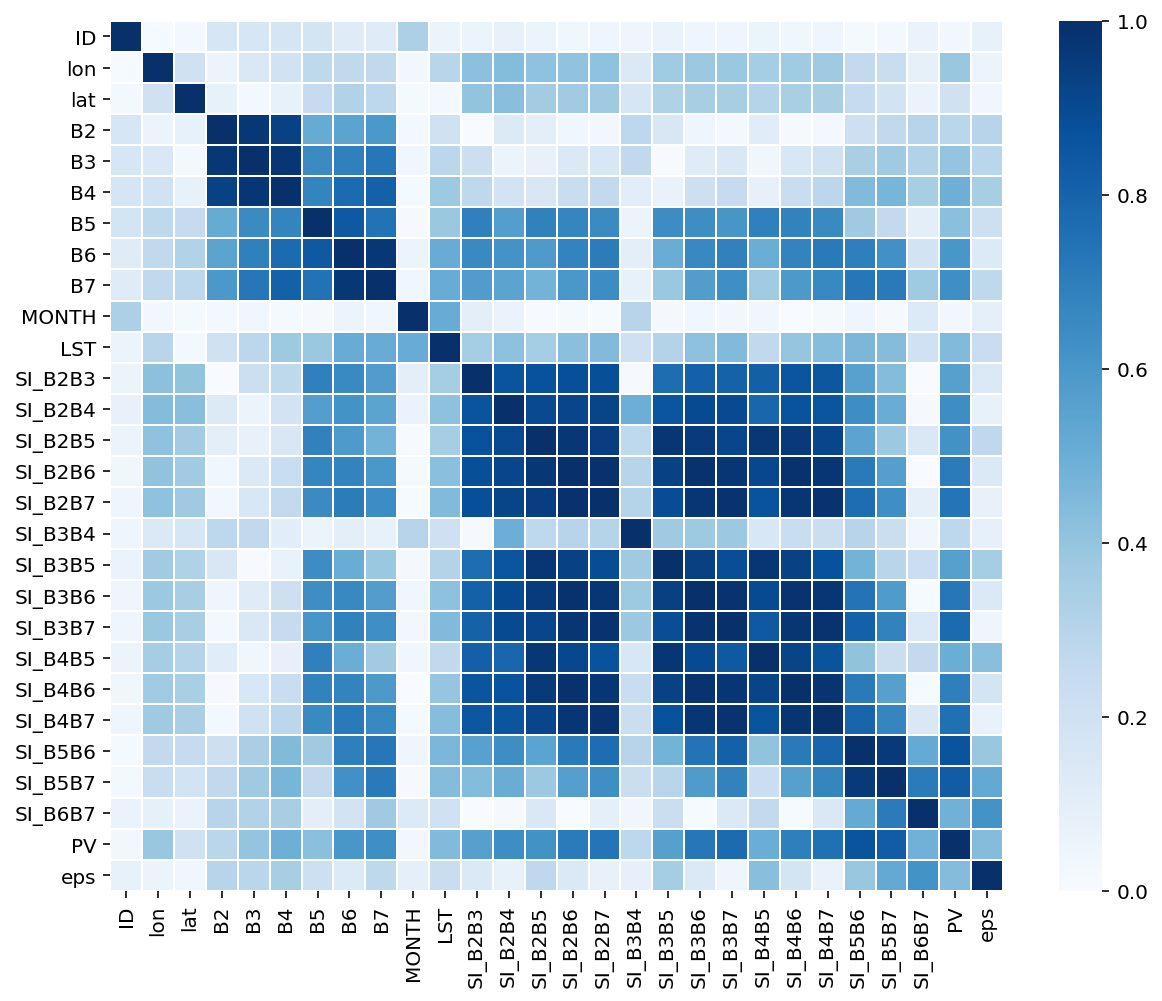

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_train.corr().abs(), vmin=0, vmax=1, cmap='Blues', center=0.5, linewidths=.5, ax=ax);
plt.show()

Observing the heatmap we can draw the following conlcusions:
- B2, B3 and B4 are strongly correlated to each other;
- B6 and B7 are strongly correlated to each other;
- The spectral indeces of the kind $SI_{B_i-B_j}$ are strongly correlated to each other, except for $SI_{B_3-B_4}$, $SI_{B_5-B_6}$, $SI_{B_5-B_7}$ and $SI_{B_6-B_7}$;
- The spectral indeces $SI_{B_5-B_6}$ and $SI_{B_5-B_7}$ are strongly correlated to each other.

Now let's look closer to correlation between features and LST.

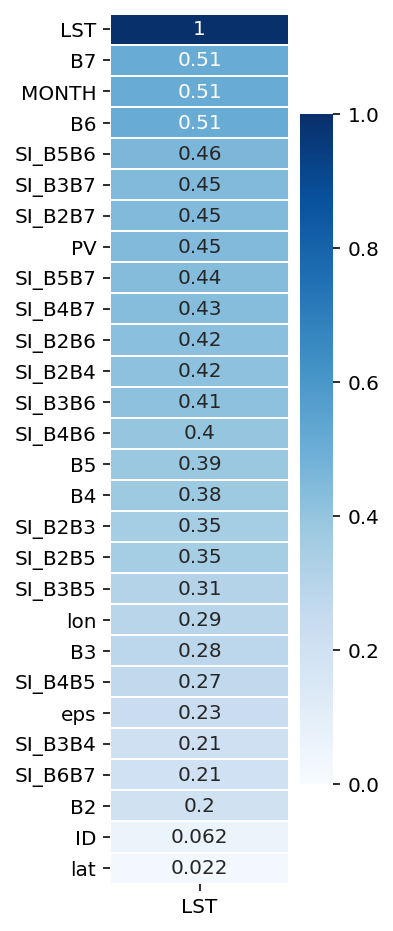

In [29]:
fig, ax = plt.subplots(figsize=(2,8))
sns.heatmap(df_train.corr().abs()[['LST']].sort_values(by='LST', ascending=False), vmin=0, vmax=1, cmap='Blues', center=0.5, annot=True, linewidths=.5, ax=ax);
plt.show()

Now, with a better understanding of correlation matrix, we can select some subsets of features that will be evaluated in the next stage.

In [30]:
basic_features = ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']

basic_features_and_indeces =  ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 
                               'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5',
                               'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7',
                               'PV', 'eps']

features_and_best_indices = ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH',
                             'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']

best_features_and_indeces = ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']

### 4.2. Principal Component Analysis (PCA)
Another feature selection technique that can be used for our purpose is **Principal component analysis** (**PCA**), which is the process of computing the principal components and using them to perform a change of basis on the data.

**Principal components** of a collection of points are orthogonal direction vectors that constitute an orthonormal basis in which different individual dimensions of the data are linearly uncorrelated.
Moreover, principal components are sorted in order of *explained variance* of the data: the first component is the direction that maximizes the variance of the data, the second component is the second direction that maximizes the variance of the data, and so on. 

PCA is used to project each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. This process is known as **dimensionality reduction**.

In [31]:
features =  ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 
                               'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5',
                               'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7',
                               'PV', 'eps']

X = df_train[features].values
y = df_train.LST.values

scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

pca = PCA()
princ_comp = pca.fit(X)
X_pca = pca.transform(X)

# princ_comp.components_

Once executed PCA, we can see the variance of the dataset explained by each principal components. The first column of the following dataframe is the absolute value of explained variance, i.e. eigenvalue, whereas the second is the ratio between the variance explained by one component and the total variance of the dataset.

In [32]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)
df_variance_PCA.head()

,explained variance,explained variance ratio
0,0.586633,0.582787
1,0.143647,0.142706
2,0.090522,0.089929
3,0.073352,0.072871
4,0.037335,0.037090


It can be useful to compute the cumulative explained variance ratio, so that we know how much variance of the data we are preserving, considering only a certain number of principal components

In [33]:
df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA

,explained variance,explained variance ratio,cumulative explained variance ratio
0,5.866328e-01,5.827873e-01,0.582787
1,1.436472e-01,1.427056e-01,0.725493
2,9.052241e-02,8.992902e-02,0.815422
3,7.335178e-02,7.287094e-02,0.888293
4,3.733515e-02,3.709041e-02,0.925383
5,3.198484e-02,3.177517e-02,0.957158
6,1.524587e-02,1.514593e-02,0.972304
7,1.087289e-02,1.080161e-02,0.983106
8,8.262101e-03,8.207941e-03,0.991314
9,4.183620e-03,4.156196e-03,0.995470


## 5. Modelling
Completed the previous stage, we can start seeking the best model for our regression problem.

### 5.1. Model selection
First of all, we perform model selection. Having a large training set, we can use a simple **holdout** techinique, splitting the training set in training and test set. The former is used to train the model, the latter is used to evaluate his performance. We repeat this process for each model and for each subset of features found in the previous section. Then we choose for a particular model the subset that lead to the best performance. This approach is also called **wrapper method**.

In [34]:
features_subsets = [basic_features, basic_features_and_indeces, features_and_best_indices, best_features_and_indeces]

#### Decision tree

In [35]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    reg = DecisionTreeRegressor()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Score on test set:  2.168912365777624
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']
Score on test set:  2.1615006927606513
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Score on test set:  2.1988413578108763
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  2.662127641149983
------------------------------------------------------------------------------


#### K-Nearest Neighbors (KNN)

In [36]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    reg = KNeighborsRegressor()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Score on test set:  1.580677173536543
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']
Score on test set:  1.8046144786976102
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Score on test set:  1.7269367855905786
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  2.025823519224108
------------------------------------------------------------------------------


#### Linear regression

In [37]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Score on test set:  5.6762837068552345
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']
Score on test set:  5.126645796930752
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Score on test set:  5.5689754309960495
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  5.869266446315997
------------------------------------------------------------------------------


#### Polinomial Regression

In [38]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    pipe = Pipeline([('poly', PolynomialFeatures(2)), ('reg', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Score on test set:  3.9377057107760196
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']
Score on test set:  2.963462088280456
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Score on test set:  3.3087455039077893
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  3.876224162321095
------------------------------------------------------------------------------


#### Ridge Regression

In [39]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    reg = Ridge()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Score on test set:  5.6797684831243425
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']
Score on test set:  5.284599390442071
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Score on test set:  5.579368259001854
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  5.869772164126891
------------------------------------------------------------------------------


#### Support Vector Machine (SVM) 

In [40]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    reg = SVR()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Score on test set:  2.547201788595868
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']
Score on test set:  2.8919670652387963
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Score on test set:  2.7185920348621786
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  2.9400056670069405
------------------------------------------------------------------------------


#### Multi Layer Perceptron (MLP)

In [41]:
for features in features_subsets:
    print('Features:', features)
    X = df_train[features].values
    y = df_train.LST.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
     
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    reg = MLPRegressor()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print('Score on test set: ', mean_absolute_error(y_test, y_pred))
    print('------------------------------------------------------------------------------')

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']


C:\Users\fabio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score on test set:  2.722054103994493
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B2B3', 'SI_B2B4', 'SI_B2B5', 'SI_B2B6', 'SI_B2B7', 'SI_B3B4', 'SI_B3B5', 'SI_B3B6', 'SI_B3B7', 'SI_B4B5', 'SI_B4B6', 'SI_B4B7', 'SI_B5B6', 'SI_B5B7', 'SI_B6B7', 'PV', 'eps']


C:\Users\fabio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score on test set:  2.536898295144014
------------------------------------------------------------------------------
Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']


C:\Users\fabio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score on test set:  2.5881978680850595
------------------------------------------------------------------------------
Features: ['B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'B5', 'B4', 'lon', 'eps']
Score on test set:  2.8930662350838565
------------------------------------------------------------------------------


C:\Users\fabio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


We might reason that KNN is the most appropriate for our problem.
However, we didn't consider that some of the previous model can gain better performance with a proper hyperparameters selection. 
For this reason we decide to continue our analysis with the following models: decision tree, KNN, SVM and MLP. On the other hand, we can discard linear, polynomial and ridge regression.

### 5.2. Hyperparameters tuning
The next step is tuning hyperparameters of the models that survived model selection. To do so, we use a technique called **grid search cross validation**, which is a brute-force search through a specified subset of the hyperparameter space. Basically it performs a k fold cross validation for every possible combination of the hyperparamters specified. Depending on the model, we set k equals to 2 or 10.

Moreover, we consider feature scaling and feature projection as part of the tuning process. Therfore, hyperparameters tuning is performed on a *pipeline* made of by a scaler, a projector (optional) and a regressor.

#### Decision Tree

In [42]:
features = basic_features
X = df_train[features].values
y = df_train.LST.values
    
print('Grid Search Cross Validation')
pipe = Pipeline([('scaler', MinMaxScaler()), ('projection', PCA()), ('reg',  DecisionTreeRegressor())])
parameters = {'scaler':[MinMaxScaler()], 'projection':['passthrough', PCA(6), PCA()], 'reg__criterion':['mse'], 'reg__splitter':['best'],
              'reg__max_depth':range(10,22,2), 'reg__min_samples_split':range(10,32,2), 
              'reg__min_samples_leaf':range(10,22,2), 'reg__random_state':[42]}
cv = KFold(n_splits=10, shuffle=True, random_state=42)

clf = GridSearchCV(estimator=pipe, param_grid=parameters, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, verbose=True, n_jobs=-1)
clf.fit(X, y)
print('Best score:', clf.best_score_)
print('Best parameters:', clf.best_params_)

best_tree = clf.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Grid Search Cross Validation
Fitting 10 folds for each of 1188 candidates, totalling 11880 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 11880 out of 11880 | elapsed: 

Best score: -1.8192240838542524
Best parameters: {'projection': 'passthrough', 'reg__criterion': 'mse', 'reg__max_depth': 18, 'reg__min_samples_leaf': 10, 'reg__min_samples_split': 30, 'reg__random_state': 42, 'reg__splitter': 'best', 'scaler': MinMaxScaler()}


#### K-Nearest Neighbors (KNN)

In [43]:
features = basic_features
X = df_train[features].values
y = df_train.LST.values

print('Grid Search Cross Validation')
pipe = Pipeline([('scaler', MinMaxScaler()), ('projection', PCA()), ('reg',  KNeighborsRegressor())])
parameters = {'scaler':[MinMaxScaler()], 'projection':['passthrough', PCA(6), PCA()], 'reg__n_neighbors':range(1, 20, 1),  'reg__weights':['distance']}
cv = KFold(n_splits=10, shuffle=True, random_state=42)

clf = GridSearchCV(estimator=pipe, param_grid=parameters, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, verbose=True, n_jobs=-1)
clf.fit(X, y)
print('Best score:', clf.best_score_)
print('Best parameters:', clf.best_params_)

best_knn = clf.best_estimator_

Grid Search Cross Validation
Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.2s


Best score: -1.524608656733292
Best parameters: {'projection': 'passthrough', 'reg__n_neighbors': 8, 'reg__weights': 'distance', 'scaler': MinMaxScaler()}


[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   32.1s finished


#### Support Vector Machine (SVM) 

In [44]:
features = basic_features
print('Features:', features)
X = df_train[features].values
y = df_train.LST.values
    
print('Grid Search Cross Validation')
pipe = Pipeline([('scaler', MinMaxScaler()), ('projection', PCA()), ('reg',  SVR())])
parameters = {'scaler':[MinMaxScaler()], 'projection':['passthrough', PCA(6), PCA()], 
              'reg__kernel':['rbf', 'linear', 'poly'],  'reg__epsilon':[0.1, 0.5, 1], 'reg__C':[0.5, 1, 2]}
cv = KFold(n_splits=2, shuffle=True, random_state=42)

clf = GridSearchCV(estimator=pipe, param_grid=parameters, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, verbose=True, n_jobs=-1)
clf.fit(X, y)
print('Best score:', clf.best_score_)
print('Best parameters:', clf.best_params_)

best_svm = clf.best_estimator_

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH']
Grid Search Cross Validation
Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
C:\Users\fabio\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 11.8min finished


Best score: -2.2347494047831242
Best parameters: {'projection': PCA(), 'reg__C': 2, 'reg__epsilon': 0.1, 'reg__kernel': 'rbf', 'scaler': MinMaxScaler()}


#### Multi Layer Perceptron (MLP)

In [45]:
features = features_and_best_indices
print('Features:', features)
X = df_train[features].values
y = df_train.LST.values
    
print('Grid Search Cross Validation')
pipe = Pipeline([('scaler', MinMaxScaler()), ('projection', PCA()), ('reg',  MLPRegressor())])
parameters = {'scaler':[MinMaxScaler()], 'projection':['passthrough', PCA(6), PCA()], 
              'reg__activation':['tanh'], 'reg__solver':['sgd'], 'reg__learning_rate':['adaptive'], 
              'reg__learning_rate_init':[0.001, 0.005, 0.01], 'reg__max_iter':[400, 600], 'reg__alpha':[0.001, 0.005, 0.01]}
cv = KFold(n_splits=2, shuffle=True, random_state=42)

clf = GridSearchCV(estimator=pipe, param_grid=parameters, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, verbose=True, n_jobs=-1)
clf.fit(X, y)
print('Best score:', clf.best_score_)
print('Best parameters:', clf.best_params_)

best_mlp = clf.best_estimator_

Features: ['lon', 'lat', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'MONTH', 'SI_B5B6', 'SI_B3B7', 'PV', 'SI_B2B4', 'eps']
Grid Search Cross Validation
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 14.0min finished


Best score: -1.7160353223825755
Best parameters: {'projection': PCA(), 'reg__activation': 'tanh', 'reg__alpha': 0.01, 'reg__learning_rate': 'adaptive', 'reg__learning_rate_init': 0.01, 'reg__max_iter': 600, 'reg__solver': 'sgd', 'scaler': MinMaxScaler()}


### 5.3. Model Evaluation
Determined the best hyperparameters of our models, we can evaluate their performance with a **10 fold cross validation**. Where possible, in term of execution time, we repeat cross valdiation 10 times.

#### Decision Tree

In [46]:
features = basic_features
X = df_train[features].values
y = df_train.LST.values

cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

score = cross_val_score(best_tree, X=X, y=y, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, n_jobs=-1)
# print(score)
print('Decision Tree MAE:', score.mean())

Decision Tree MAE: -1.82496508760302


#### K-Nearest Neighbors (KNN)

In [47]:
features = basic_features
X = df_train[features].values
y = df_train.LST.values

cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

score = cross_val_score(best_knn, X=X, y=y, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, n_jobs=-1)
# print(score)
print('KNN MAE:', score.mean())

KNN MAE: -1.5263072066533787


#### Support Vector Machine (SVM) 

In [48]:
features = basic_features
X = df_train[features].values
y = df_train.LST.values

cv = KFold(n_splits=10, shuffle=True, random_state=42)

score = cross_val_score(best_svm, X=X, y=y, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, n_jobs=-1)
# print(score)
print('SVM MAE:', score.mean())

SVM MAE: -2.147411613290887


#### Multi Layer Perceptron (MLP)

In [49]:
features = features_and_best_indices
X = df_train[features].values
y = df_train.LST.values

cv = KFold(n_splits=10, shuffle=True, random_state=42)

score = cross_val_score(best_mlp, X=X, y=y, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, n_jobs=-1)
# print(score)
print('MLP MAE:', score.mean())

[-1.6684964  -1.71545694 -1.67078613 -1.65088021 -1.72505171 -1.7083243
 -1.71272863 -1.77018887 -1.64145003 -1.73083013]
MLP MAE: -1.6994193334254184


As we can see, hyperparamters tuning significantly improved performance of some models, such as decision tree and MLP. Nevertheless, the best mode is still KNN, so we choose it as final model.

## 6. Submission
We can finally create our submission file. First we train our final model using the whole training set, then we predict the class label for the instances of the (original) test set.

In [50]:
df_sub = df_test.copy()

#### K-Nearest Neighbors (KNN)

In [51]:
features = basic_features

X_train = df_train[features].values
y_train = df_train.LST.values
X_test = df_test[features].values

best_knn.fit(X_train, y_train)
y_test = best_knn.predict(X_test)
df_sub['LST'] = y_test

We can look at the class distribution of the test instances.

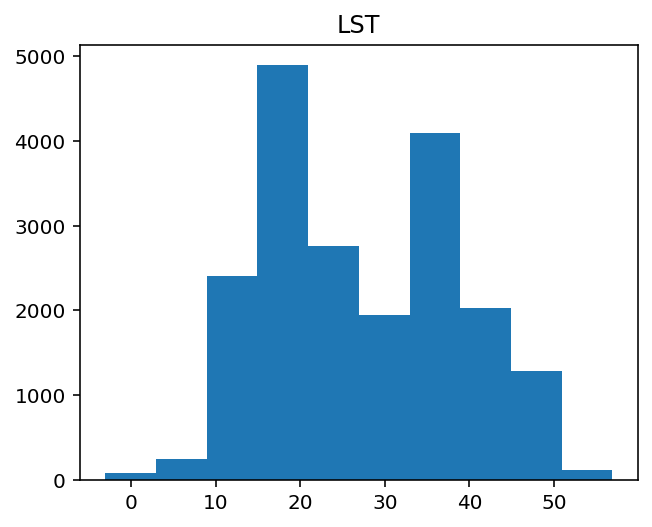

In [52]:
df_sub.hist(column=['LST'], figsize=(5,4), grid=False)
plt.show()

In [53]:
df_sub[['ID', 'LST']].to_csv('submission/sub_knn.csv', index=False)

In the private leaderboard of Kaggle's competition we can see that model's MAE is 1.50974, which means that in the previous section we found an accurate estimation.